<a href="https://colab.research.google.com/github/TheodorIvanov/ML_Group_J/blob/master/summer_project_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [2]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file
import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

 74% 49.0M/66.0M [00:01<00:00, 23.0MB/s]
100% 66.0M/66.0M [00:01<00:00, 42.7MB/s]


## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
sns.set_palette("Set2")
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.layers import *
from keras import losses
from keras import optimizers
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

seed = 66

# Supressing  Warnings

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# Functions

def LossGraph(history):
  plt.figure(figsize = (12,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show();

def ReconstructionScatter(cleared, frauds, threshold): 
  plt.figure(figsize = (12,9))
  plt.scatter(cleared.index, cleared.values, marker = 'o', label = 'Cleared')
  plt.scatter(frauds.index, frauds.values, marker = 'x', label = 'Fraud')
  plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors = 'r', label = 'Threshold')
  plt.legend(loc = 'best')
  plt.title('Reconstructed Transactions')
  plt.xlabel('Transaction ID')
  plt.ylabel('Root Reconstruction Error')
  plt.show();

def ModelPerformance(X_test, y_test, prediction):
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap='RdBu', fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show();
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Sampling

In [48]:
# Scaling the data

df = pd.read_csv('creditcard.csv')
scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)),
                      columns=df.drop(['Time','Class'],axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

## Model 1: Simple Autoencoder

In [5]:
# latent = 9 # dimension of the latent vector
# batch_size = 128
# epochs = 100

# # Defining the Model

# inputs = Input(shape=(input_dim,), name = 'input_encoder')

# encoder = Dense(18, activation='relu')(inputs)
# encoder = Dense(12, activation='relu')(encoder)

# bottleneck  = Dense(latent, activation='relu')(encoder)

# decoder = Dense(12, activation='relu')(bottleneck)
# decoder = Dense(18, activation='relu')(decoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

# autoencoder_1 = Model(inputs,decoder)
# # autoencoder_1.summary()
# # keras.utils.plot_model(autoencoder_1, show_shapes=True)

# # Compiling the model

# autoencoder_1.compile(optimizer=keras.optimizers.Adam(),
#                       loss = losses.mean_squared_error,
#                       metrics = ['mae','accuracy'])

# # Early Stopper

# stopper = EarlyStopping(monitor = 'val_loss',
#                         min_delta = 0.005,
#                         verbose = 1,
#                         patience = 5,
#                         restore_best_weights = True)

# # Training

# history = autoencoder_1.fit(X_train, X_train,
#                             batch_size = batch_size,
#                             epochs = epochs,
#                             verbose = 2,
#                             validation_data = (X_test, X_test),
#                             callbacks = [stopper])

# LossGraph(history)

# # Predicting

# predictions = autoencoder_1.predict(X_test)

# # Reconstruction error (RMSE)

# rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# # Reconstructed data

# reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

# frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
# cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# # Predicting the class using the threshtold

# threshold = 5

# reconstructed['pred_class'] = 0
# reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# # Model Performance

# ReconstructionScatter(cleared, frauds, threshold = threshold)
# ModelPerformance(X_test, y_test, reconstructed.pred_class)

## Feature Selection

In [53]:
# Feature Selection

#scaled = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]]
scaled = scaled[['V17','V14','V12','V10', 'V16', 'V11', 'Class']]

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

## Model 2: Feature Selection Optimised

Train on 227448 samples, validate on 56962 samples
Epoch 1/100
 - 3s - loss: 0.4685 - mae: 0.4077 - accuracy: 0.8840 - val_loss: 0.5423 - val_mae: 0.3836 - val_accuracy: 0.9499
Epoch 2/100
 - 3s - loss: 0.4399 - mae: 0.3639 - accuracy: 0.9642 - val_loss: 0.5388 - val_mae: 0.3675 - val_accuracy: 0.9716
Epoch 3/100
 - 3s - loss: 0.4389 - mae: 0.3552 - accuracy: 0.9781 - val_loss: 0.5380 - val_mae: 0.3606 - val_accuracy: 0.9836
Epoch 4/100
 - 2s - loss: 0.4386 - mae: 0.3514 - accuracy: 0.9842 - val_loss: 0.5378 - val_mae: 0.3591 - val_accuracy: 0.9860
Epoch 5/100
 - 3s - loss: 0.4385 - mae: 0.3495 - accuracy: 0.9874 - val_loss: 0.5377 - val_mae: 0.3561 - val_accuracy: 0.9922
Epoch 6/100
 - 3s - loss: 0.4385 - mae: 0.3487 - accuracy: 0.9884 - val_loss: 0.5376 - val_mae: 0.3575 - val_accuracy: 0.9910
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


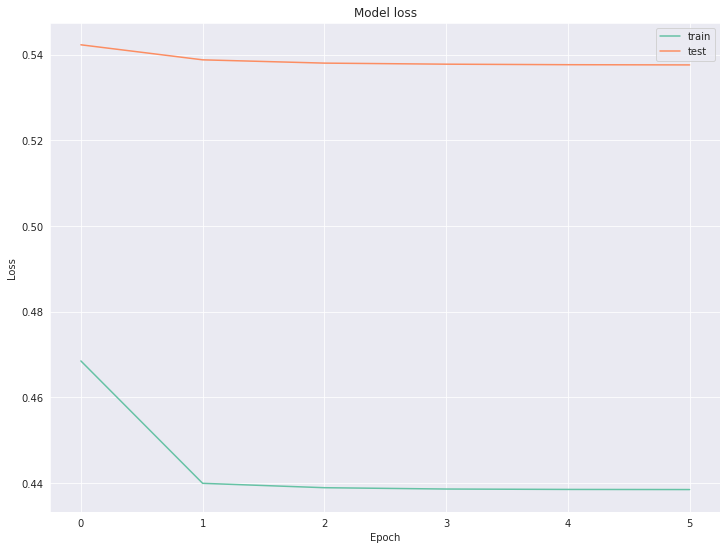

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


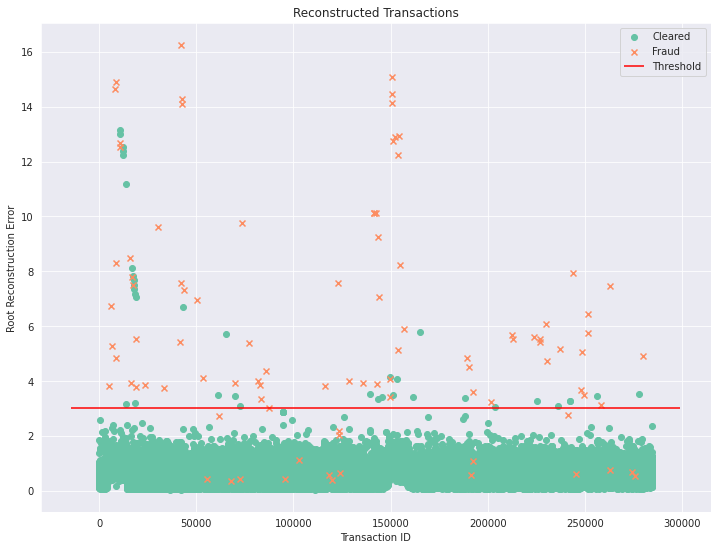


 Confusion Matrix 



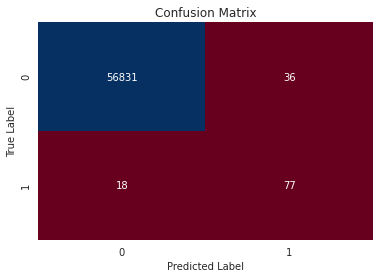


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.68      0.81      0.74        95

    accuracy                           1.00     56962
   macro avg       0.84      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [54]:
latent = 50 # dimension of the latent vector 5 
batch_size = 128
epochs = 100

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(15, activation='relu')(inputs) # 6
encoder = Dense(20, activation='relu')(encoder) # 9

bottleneck  = Dense(latent, activation='relu')(encoder)

decoder = Dense(20, activation='relu')(bottleneck)
decoder = Dense(15, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_2 = Model(inputs,decoder)
# autoencoder_2.summary()
# keras.utils.plot_model(autoencoder_2, show_shapes=True)

# Compiling the model

autoencoder_2.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error, # mse
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_2.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history)

# Predicting

predictions = autoencoder_2.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 3

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold)
ModelPerformance(X_test, y_test, reconstructed.pred_class)

Feature ranking:
1. feature 16 (0.147953)
2. feature 13 (0.118162)
3. feature 11 (0.111965)
4. feature 9 (0.076765)
5. feature 15 (0.069594)
6. feature 10 (0.061561)
7. feature 3 (0.040644)
8. feature 17 (0.039947)
9. feature 8 (0.035875)
10. feature 2 (0.032191)
11. feature 6 (0.024215)
12. feature 20 (0.017753)
13. feature 1 (0.015449)
14. feature 25 (0.015307)
15. feature 18 (0.014948)
16. feature 7 (0.014498)
17. feature 19 (0.014083)
18. feature 4 (0.013868)
19. feature 5 (0.013786)
20. feature 0 (0.013704)
21. feature 26 (0.013256)
22. feature 21 (0.013142)
23. feature 14 (0.012961)
24. feature 23 (0.012510)
25. feature 28 (0.012026)
26. feature 27 (0.011855)
27. feature 12 (0.011688)
28. feature 24 (0.010881)
29. feature 22 (0.009412)


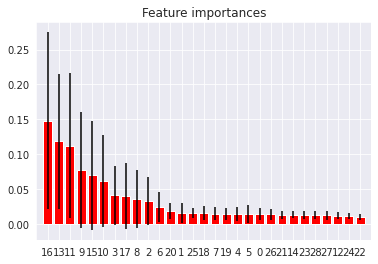

In [27]:
### FEATURE SELECTION

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=seed)

y = scaled['Class']
X = scaled.drop(['Class'],axis=1)


forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [8]:
# import time
# for i in range(60):
#   time.sleep(60)
#   print(i)